In [10]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [11]:
# Simulation parameters
resolution = 10 # pixels/um
pml_thickness = 2
dim = 10
cell_x = dim
cell_y = dim
cell_z = dim

sphere_radius = 1.0
substrate_eps = 2.56
frequency = 1.0

cell_size = mp.Vector3(cell_x, cell_y, cell_z)

# Plane wave incidence defined by polar and azimuthal angles (in degrees)
theta_deg = 0  # Polar angle from +Z
phi_deg = 0    # Azimuthal angle in x–y plane

# Convert to radians
theta = np.radians(theta_deg)
phi = np.radians(phi_deg)

# Build normalized k-vector
k_unit = mp.Vector3(
    np.sin(theta) * np.cos(phi),
    np.sin(theta) * np.sin(phi),
    -np.cos(theta)  # negative for downward propagation
)

# Scale for Meep's eig_kpoint (|k| = frequency in Meep units)
eig_kpoint = k_unit.scale(frequency)



In [12]:
# Define your substrate material
substrate_material = mp.Medium(epsilon=2.56)

# Material function: homogeneous material for z < 0
def bump_surface_material(p):
    return substrate_material if p.z < 0 else mp.air

# Safe eigenmode volume (non-zero in 2 directions)
def make_valid_eig_vol(k_vec, size, resolution):
    """Generate a valid eig_vol size (2D cross-section orthogonal to k_vec)."""
    k = np.array([k_vec.x, k_vec.y, k_vec.z])
    k /= np.linalg.norm(k)

    # Find two orthogonal vectors perpendicular to k
    perp1 = np.cross(k, [1, 0, 0])
    if np.linalg.norm(perp1) < 1e-6:
        perp1 = np.cross(k, [0, 1, 0])
    perp1 /= np.linalg.norm(perp1)
    perp2 = np.cross(k, perp1)
    perp2 /= np.linalg.norm(perp2)

    # Build size vector by summing contributions from perp1 and perp2
    vol_size_vec = np.abs(perp1) * size + np.abs(perp2) * size

    # Ensure at least 1 pixel per direction
    vol_size_vec = np.maximum(vol_size_vec, 1 / resolution)

    return mp.Vector3(*vol_size_vec)

vol_size = make_valid_eig_vol(eig_kpoint, cell_x, resolution)

# Adjust smallest component to ensure valid 2D source plane
vol_size_array = np.array([vol_size.x, vol_size.y, vol_size.z])
sorted_indices = np.argsort(vol_size_array)
vol_size_array[sorted_indices[0]] = 0.0  # Set one dimension to exactly zero for valid EigenModeSource
safe_vol_size = mp.Vector3(*vol_size_array)

eig_vol = mp.Volume(
    center=mp.Vector3(0, 0, 0.5 * cell_z - pml_thickness - 1),
    size=safe_vol_size
)

sources = [
    mp.EigenModeSource(
        src=mp.ContinuousSource(frequency=frequency),
        center=mp.Vector3(0, 0, 0.5 * cell_z - pml_thickness - 1),
        size=safe_vol_size,
        direction=mp.NO_DIRECTION,
        eig_kpoint=eig_kpoint,
        eig_band=1,
        eig_match_freq=True,
        eig_parity=mp.EVEN_Y + mp.ODD_Z,  # TE
        eig_vol=eig_vol
    )
]

# PMLs on all sides
pml_layers = [
    mp.PML(thickness=pml_thickness, direction=mp.X),
    mp.PML(thickness=pml_thickness, direction=mp.Y),
    mp.PML(thickness=pml_thickness, direction=mp.Z),
]

sim = mp.Simulation(
    cell_size=cell_size,
    resolution=resolution,
    boundary_layers=pml_layers,
    sources=sources,
    default_material=bump_surface_material
)

# Add flux monitors (six directions)
flux_regions = {
    'top':    mp.FluxRegion(center=mp.Vector3(0, 0, 0.5*cell_z - pml_thickness - 0.1), size=mp.Vector3(cell_x, cell_y, 0)),
    'bottom': mp.FluxRegion(center=mp.Vector3(0, 0, -0.5*cell_z + pml_thickness + 0.1), size=mp.Vector3(cell_x, cell_y, 0)),
    'left':   mp.FluxRegion(center=mp.Vector3(-0.5*cell_x + pml_thickness + 0.1, 0, 0), size=mp.Vector3(0, cell_y, cell_z)),
    'right':  mp.FluxRegion(center=mp.Vector3(0.5*cell_x - pml_thickness - 0.1, 0, 0), size=mp.Vector3(0, cell_y, cell_z)),
    'front':  mp.FluxRegion(center=mp.Vector3(0, -0.5*cell_y + pml_thickness + 0.1, 0), size=mp.Vector3(cell_x, 0, cell_z)),
    'back':   mp.FluxRegion(center=mp.Vector3(0, 0.5*cell_y - pml_thickness - 0.1, 0), size=mp.Vector3(cell_x, 0, cell_z)),
}

flux_monitors = {name: sim.add_flux(frequency, 0, 1, region)
                 for name, region in flux_regions.items()}

# Run the simulation
sim.run(until=60)


-----------
Initializing structure...
time for choose_chunkdivision = 0.0576379 s
Working in 3D dimensions.
Computational cell is 10 x 10 x 10 with resolution 10
subpixel-averaging is 32.6221% done, 8.28025 s remaining
subpixel-averaging is 61.3495% done, 2.52016 s remaining
subpixel-averaging is 77.9043% done, 1.3156 s remaining
subpixel-averaging is 88.6162% done, 0.518265 s remaining
subpixel-averaging is 83.7471% done, 0.777547 s remaining
subpixel-averaging is 49.1769% done, 4.13458 s remaining
time for set_epsilon = 118.842 s
-----------


RuntimeError: meep: invalid volume dimensionality in add_eigenmode_source

In [ ]:
def plot_field_slice_with_bumps(abs_E, axis='y', index=None, projection=False,
                                 extent=None, cmap_field='inferno',
                                 Z=None, contour_levels=10, cmap_contour='plasma',
                                 alpha_contour=0.5, title=None):
    """
    Plot a 2D slice or projection of a 3D field with optional bump surface contours.

    Parameters:
    - abs_E: 3D numpy array (shape [x, y, z])
    - axis: 'x', 'y', or 'z' — axis to slice or project along
    - index: slice index if not projecting (defaults to center)
    - projection: if True, take max projection along the axis
    - extent: (xmin, xmax, ymin, ymax) for plot axes
    - cmap_field: colormap for |E|
    - Z: optional 2D bump surface (shape [x, y]); will be transposed and flipped to match
    - contour_levels: number of contour levels
    - cmap_contour: colormap for contours
    - alpha_contour: transparency of contours
    - title: plot title
    """
    axis_dict = {'x': 0, 'y': 1, 'z': 2}
    ax = axis_dict[axis]

    # Default extent if none provided
    extent = extent or [-1, 1, -1, 1]

    if projection:
        slice_2d = np.max(abs_E, axis=ax)
        label = f'Max projection along {axis.upper()}'
        # Transpose for correct display orientation (Y vertical, X horizontal)
        if axis == 'z':
            slice_2d = slice_2d.T
    else:
        if index is None:
            index = abs_E.shape[ax] // 2
        slicer = [slice(None)] * 3
        slicer[ax] = index
        slice_2d = abs_E[tuple(slicer)]
        label = f'Slice at {axis.upper()} = {index}'
        # Transpose if slicing along x or y for proper display
        if axis in ['x', 'y']:
            slice_2d = slice_2d.T

    # Plot the field slice
    plt.figure(dpi=100, figsize=(7, 6))
    plt.imshow(slice_2d, cmap=cmap_field, origin='lower', extent=extent)
    plt.colorbar(label='|E|')

    # Optional: overlay contour from bump surface
    if Z is not None:
        Z_plot = Z  # Flip and transpose to match imshow orientation
        plt.contour(Z_plot, levels=contour_levels, extent=extent,
                    cmap=cmap_contour, alpha=alpha_contour)

    # Axis labels
    if axis == 'x':
        plt.xlabel("y (µm)")
        plt.ylabel("z (µm)")
    elif axis == 'y':
        plt.xlabel("x (µm)")
        plt.ylabel("z (µm)")
    elif axis == 'z':
        plt.xlabel("x (µm)")
        plt.ylabel("y (µm)")

    plt.title(title or label)
    plt.tight_layout()
    plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_field_with_bumps(abs_E, Z, extent, axis='z', cmap_field='inferno', cmap_contour='plasma', alpha_contour=0.5, title=None):
    """
    Overlay a bump surface Z(x, y) as contours on top of a 2D projection of |E| from abs_E.

    Parameters:
    - abs_E: 3D numpy array (shape: x, y, z)
    - Z: 2D bump surface (shape: X, Y)
    - extent: (xmin, xmax, ymin, ymax) — must match both field and surface
    - axis: projection axis ('x', 'y', 'z')
    - cmap_field: colormap for |E| background
    - cmap_contour: colormap for bump contours
    - alpha_contour: opacity of contours
    - title: optional plot title
    """
    axis_dict = {'x': 0, 'y': 1, 'z': 2}
    ax = axis_dict[axis]

    # Project the field
    field_proj = np.max(abs_E, axis=ax)

    # For z-projection, transpose to get (y, x) orientation for imshow
    if axis == 'z':
        field_proj = field_proj.T

    # Transpose Z to align with imshow
    Z_plot = Z # transpose


    # Plot
    plt.figure(figsize=(7, 6), dpi=100)
    plt.imshow(field_proj, cmap=cmap_field, origin='lower', extent=extent)
    plt.contour(Z_plot, levels=10, extent=extent, cmap=cmap_contour, alpha=alpha_contour)
    plt.colorbar(label='|E|')
    plt.xlabel('x (μm)')
    plt.ylabel('y (μm)')
    plt.title(title or f'Max |E| with Bump Contours (projection along {axis})')
    plt.tight_layout()
    plt.show()


In [ ]:
# Print flux values
for name, monitor in flux_monitors.items():
    flux_val = mp.get_fluxes(monitor)[0]
    print(f"Flux through {name}: {flux_val:.6f}")

# Assume abs_E is shape (160, 12, 160) → (x, y, z)

# Full 3D array extraction
ex = sim.get_array(center=mp.Vector3(), size=mp.Vector3(cell_x, cell_y, cell_z), component=mp.Ex)
ey = sim.get_array(center=mp.Vector3(), size=mp.Vector3(cell_x, cell_y, cell_z), component=mp.Ey)
ez = sim.get_array(center=mp.Vector3(), size=mp.Vector3(cell_x, cell_y, cell_z), component=mp.Ez)

# Total magnitude
abs_E = np.sqrt(np.abs(ex)**2 + np.abs(ey)**2 + np.abs(ez)**2)


# === Print total flux through each monitor ===
for name, monitor in flux_monitors.items():
    flux_val = mp.get_fluxes(monitor)[0]
    print(f"Flux through {name}: {flux_val:.6f}")

# === Full 3D Electric Field Extraction ===
# Assume simulation has finished and fields are stored in the simulation domain

# Extract Ex, Ey, Ez components from the full cell
ex = sim.get_array(center=mp.Vector3(), size=mp.Vector3(cell_x, cell_y, cell_z), component=mp.Ex)
ey = sim.get_array(center=mp.Vector3(), size=mp.Vector3(cell_x, cell_y, cell_z), component=mp.Ey)
ez = sim.get_array(center=mp.Vector3(), size=mp.Vector3(cell_x, cell_y, cell_z), component=mp.Ez)

# Compute total electric field magnitude |E| = sqrt(Ex² + Ey² + Ez²)
abs_E = np.sqrt(np.abs(ex)**2 + np.abs(ey)**2 + np.abs(ez)**2)

# Optional: save field for later reuse
np.save("abs_E.npy", abs_E)

Flux through top: 35.064896
Flux through bottom: -361.727455
Flux through left: 4.870914
Flux through right: -4.870950
Flux through front: 4.657120
Flux through back: -4.657200
Flux through top: 35.064896
Flux through bottom: -361.727455
Flux through left: 4.870914
Flux through right: -4.870950
Flux through front: 4.657120
Flux through back: -4.657200


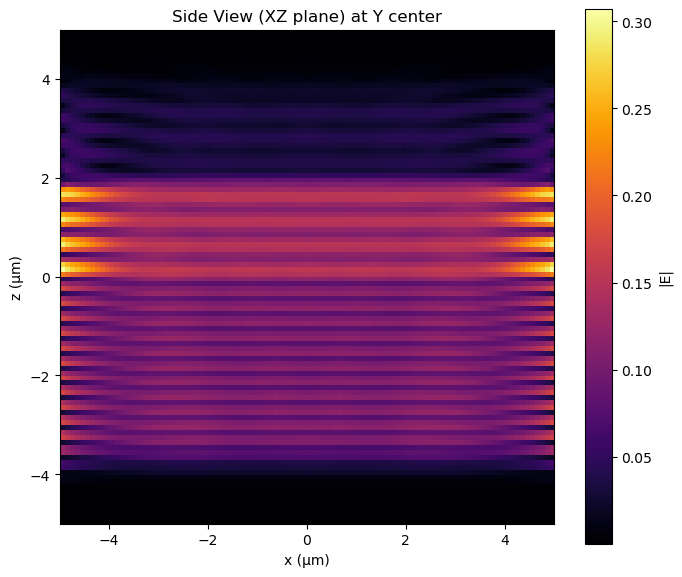

In [ ]:
plot_field_slice_with_bumps(
    abs_E=abs_E,
    axis='y',
    index=abs_E.shape[1] // 2,
    extent=extent,
    title="Side View (XZ plane) at Y center"
)



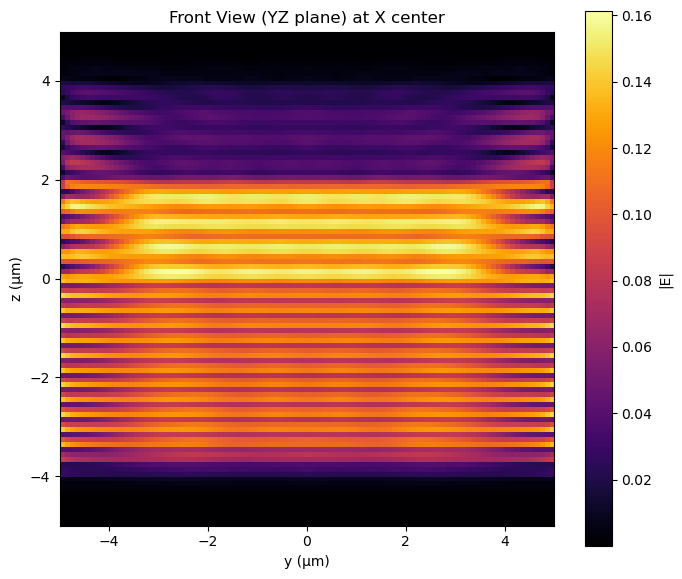

In [ ]:
plot_field_slice_with_bumps(
    abs_E=abs_E,
    axis='x',
    index=abs_E.shape[0] // 2,
    extent=extent,
    title="Front View (YZ plane) at X center"
)


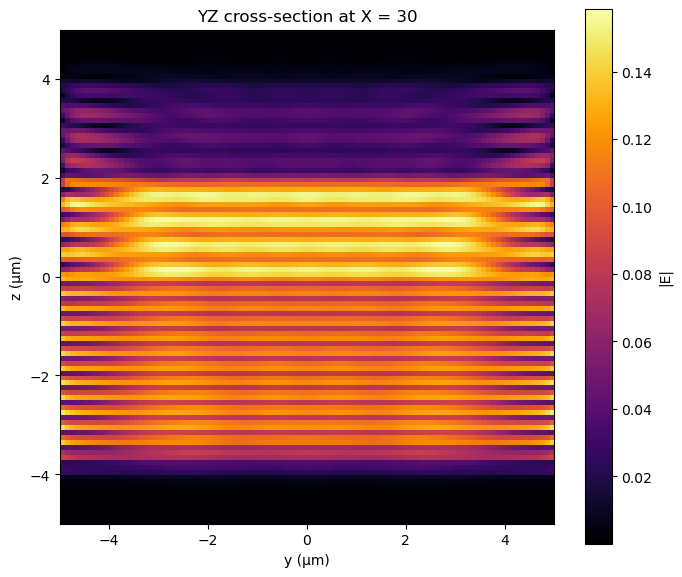

In [ ]:
plot_field_slice_with_bumps(
    abs_E=abs_E,
    axis='x',
    index=30,
    extent=extent,
    title="YZ cross-section at X = 30"
)


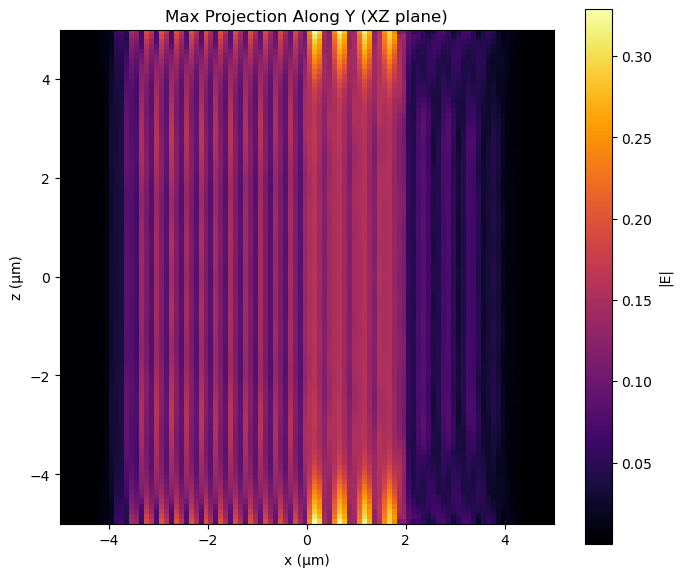

In [ ]:
plot_field_slice_with_bumps(
    abs_E=abs_E,
    axis='y',
    projection=True,
    extent=extent,
    title="Max Projection Along Y (XZ plane)"
)


In [ ]:
def plot_field_volume(field_data, component_label, size_um, resolution_um, downsample_factor=4):
    """
    Plot a 3D volume of the real part of a field using Plotly with optional downsampling.

    Parameters:
        field_data: 3D numpy array of the field (Ex, Ey, Ez).
        component_label: str, one of "Ex", "Ey", "Ez".
        size_um: float, physical simulation size in microns.
        resolution_um: int, number of pixels per micron.
        downsample_factor: int, how much to reduce resolution (e.g., 2, 4).
    """
    # Downsample the field
    field_real = np.real(field_data)[::downsample_factor, ::downsample_factor, ::downsample_factor]

    # Build axis
    N = field_real.shape[0]
    lin = np.linspace(-size_um / 2, size_um / 2, N)
    x, y, z = np.meshgrid(lin, lin, lin, indexing="ij")

    fig = go.Figure(data=go.Volume(
        x=x.flatten(), y=y.flatten(), z=z.flatten(),
        value=field_real.flatten(),
        isomin=np.min(field_real),
        isomax=np.max(field_real),
        opacity=0.15,
        surface_count=15,
        colorscale="RdBu",
        colorbar=dict(title=f"Re({component_label})")
    ))

    fig.update_layout(
        scene=dict(
            xaxis_title='x (μm)',
            yaxis_title='y (μm)',
            zaxis_title='z (μm)'
        ),
        title=f"3D Volume Plot of Re({component_label})"
    )
    fig.write_html(f"Re_{component_label}_3Dplot.html")


In [ ]:
# Define physical domain size and resolution (match your simulation)
size_um = 10.0
resolution_um = 10

In [ ]:
import plotly.graph_objects as go

plot_field_volume(ex, "Ex", size_um=size_um, resolution_um=resolution_um, downsample_factor=4)
plot_field_volume(ey, "Ey", size_um=size_um, resolution_um=resolution_um, downsample_factor=4)
plot_field_volume(ez, "Ez", size_um=size_um, resolution_um=resolution_um, downsample_factor=4)


In [ ]:
def plot_abs_field_volume(Ex, Ey, Ez, resolution_um=20, size_um=10.0, downsample_factor=4):
    """Plot |E| = sqrt(Re(Ex)^2 + Re(Ey)^2 + Re(Ez)^2) in 3D using Plotly, with optional downsampling."""
    # Downsample and compute real parts
    Ex_real = np.real(Ex)[::downsample_factor, ::downsample_factor, ::downsample_factor]
    Ey_real = np.real(Ey)[::downsample_factor, ::downsample_factor, ::downsample_factor]
    Ez_real = np.real(Ez)[::downsample_factor, ::downsample_factor, ::downsample_factor]

    # Compute magnitude
    Eabs = np.sqrt(Ex_real**2 + Ey_real**2 + Ez_real**2)

    # Generate coordinates
    nx, ny, nz = Eabs.shape
    x = np.linspace(-size_um / 2, size_um / 2, nx)
    y = np.linspace(-size_um / 2, size_um / 2, ny)
    z = np.linspace(-size_um / 2, size_um / 2, nz)
    X, Y, Z = np.meshgrid(x, y, z, indexing="ij")

    # Plot
    fig = go.Figure(data=go.Volume(
        x=X.flatten(), y=Y.flatten(), z=Z.flatten(),
        value=Eabs.flatten(),
        isomin=0.1 * np.max(Eabs), isomax=np.max(Eabs),
        opacity=0.1,
        surface_count=15,
        colorscale="Viridis",
        caps=dict(x_show=False, y_show=False, z_show=False)
    ))
    fig.update_layout(
        scene=dict(
            xaxis_title="x (μm)",
            yaxis_title="y (μm)",
            zaxis_title="z (μm)"
        ),
        title="|E| field magnitude"
    )
    fig.write_html("abs_E_field_volume.html")


In [ ]:
plot_abs_field_volume(ex, ey, ez, resolution_um=resolution_um, size_um=size_um, downsample_factor=4)


In [ ]:
import plotly.graph_objects as go
import numpy as np

def plot_E_vector_field(ex, ey, ez, size_um=10.0, downsample_factor=4, scale=1.5):
    """
    Plot a 3D vector field (Ex, Ey, Ez) using Plotly Cone plot.

    Parameters:
        ex, ey, ez: 3D numpy arrays (field components).
        size_um: physical size of the domain in microns.
        downsample_factor: factor to reduce resolution for plotting.
        scale: scaling factor for vector length.
    """
    # Downsample
    ex_ds = ex[::downsample_factor, ::downsample_factor, ::downsample_factor]
    ey_ds = ey[::downsample_factor, ::downsample_factor, ::downsample_factor]
    ez_ds = ez[::downsample_factor, ::downsample_factor, ::downsample_factor]

    # Get grid
    nx, ny, nz = ex_ds.shape
    lin_x = np.linspace(-size_um/2, size_um/2, nx)
    lin_y = np.linspace(-size_um/2, size_um/2, ny)
    lin_z = np.linspace(-size_um/2, size_um/2, nz)
    X, Y, Z = np.meshgrid(lin_x, lin_y, lin_z, indexing="ij")

    # Flatten all
    fig = go.Figure(data=go.Cone(
        x=X.flatten(),
        y=Y.flatten(),
        z=Z.flatten(),
        u=np.real(ex_ds).flatten() * scale,
        v=np.real(ey_ds).flatten() * scale,
        w=np.real(ez_ds).flatten() * scale,
        sizemode="absolute",
        sizeref=0.5,
        anchor="tail",
        colorscale="Viridis"
    ))

    fig.update_layout(
        scene=dict(
            xaxis_title='x (μm)',
            yaxis_title='y (μm)',
            zaxis_title='z (μm)'
        ),
        title="E-field Vectors in 3D (Re[E])"
    )
    fig.write_html("E_vector_field_cone.html")


In [ ]:
plot_E_vector_field(ex, ey, ez, size_um=size_um, downsample_factor=4)
